In [58]:
import os
import gc
import sys
import yaml
import time
import glob
import wave
import faiss

import random
import librosa

import numpy as np
import pandas as pd
import deepdish as dd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from model_RA.fp_RA.nnfp import get_fingerprinter
from model_RA.fp_RA.melspec.melspectrogram_RA import get_melspec_layer

Construção Faiss

In [ ]:
def create_index(db_embeddings, nogpu=True, n_centroids=256, code_sz=64, nbits=8):
    #faiss.IndexIVFPQ(quantizer, d, n_centroids, code_sz, nbits), com d=, nlist=n_centroids=50, m=code_sz=8, bits=nbits=8
    #faiss.IndexIVFPQ(quantizer, d, nlist, m, bits)
    #n_centroids -> clusters

    # GPU Setup
    if not nogpu:
        GPU_RESOURCES = faiss.StandardGpuResources()
        GPU_OPTIONS = faiss.GpuClonerOptions()
        GPU_OPTIONS.useFloat16 = True # use float16 table to avoid https://github.com/facebookresearch/faiss/issues/1178
    else:
        pass
    

    # Fingerprint dimension, d
    d = db_embeddings.shape[1] #len(db_embeddings[0][0]) #db_embeddings.shape[1]  # Dim emb #len(db_embeddings[0][0][0])


    # Build a flat (CPU) index
    quantizer = faiss.IndexFlatL2(d)


    # Using IVF-PQ index
    code_sz = 64 # power of 2
    n_centroids = 256 # Number of Veronoi Cells (?)
    nbits = 8  # nbits must be 8, 12 or 16, The dimension d should be a multiple of M.
    index = faiss.IndexIVFPQ(quantizer, d, n_centroids, code_sz, nbits) #Adicona clustering


    # Se não usar GPU
    if not nogpu:
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0, index)

    max_nitem_train = int(1e7)
    # Train index
    if not index.is_trained:
        #print('Training index using {:>3.2f} % of data...'.format(100. * max_nitem_train / len(db_embeddings)))
        #sel_tr_idx = np.random.permutation(len(db_embeddings))
        #sel_tr_idx = sel_tr_idx[:max_nitem_train]
        #index.train(db_embeddings[sel_tr_idx,:])
        index.train(db_embeddings)
    

    # N probe
    index.nprobe = 40
    return index

In [3]:
def load_memmap_data(source_dir,
                     fname,
                     append_extra_length=None,
                     shape_only=False,
                     display=True):
    """
    Load data and datashape from the file path.

    • Get shape from [source_dir/.npy}.
    • Load memmap data from [source_dir/fname.mm].

    Parameters
    ----------
    source_dir : (str)
    fname : (str)
        File name except extension.
    append_empty_length : None or (int)
        Length to appened empty vector when loading memmap. If activate, the
        file will be opened as 'r+' mode.
    shape_only : (bool), optional
        Return only shape. The default is False.
    display : (bool), optional
        The default is True.

    Returns
    -------
    (data, data_shape)

    """
    path_shape = source_dir + fname + '_shape.npy'
    path_data = source_dir + fname + '.mm'
    data_shape = np.load(path_shape)
    if shape_only:
        return data_shape

    if append_extra_length:
        data_shape[0] += append_extra_length
        data = np.memmap(path_data, dtype='float32', mode='r+',
                         shape=(data_shape[0], data_shape[1]))
    else:
        data = np.memmap(path_data, dtype='float32', mode='r',
                         shape=(data_shape[0], data_shape[1]))
    if display:
        print(f'Load {data_shape[0]:,} items from \033[32m{path_data}\033[0m.')
    return data, data_shape

In [4]:
emb_dir = '/mnt/dev/rodrigoalmeida/neural-audio-fp/logs/emb/CHECK_BFTRI_100/101/'
emb_dummy_dir = None

In [5]:
# Load items from {query, db, dummy_db}
query, query_shape = load_memmap_data(emb_dir, 'query')
db, db_shape = load_memmap_data(emb_dir, 'db')
if emb_dummy_dir is None:
    emb_dummy_dir = emb_dir
dummy_db, dummy_db_shape = load_memmap_data(emb_dummy_dir, 'dummy_db')

Load 29,500 items from /mnt/dev/rodrigoalmeida/neural-audio-fp/logs/emb/CHECK_BFTRI_100/101/query.mm.
Load 29,500 items from /mnt/dev/rodrigoalmeida/neural-audio-fp/logs/emb/CHECK_BFTRI_100/101/db.mm.
Load 53,754,198 items from /mnt/dev/rodrigoalmeida/neural-audio-fp/logs/emb/CHECK_BFTRI_100/101/dummy_db.mm.


In [6]:
max_nitem_train = int(1e7)
print('Training index using {:>3.2f} % of data...'.format(100. * max_nitem_train / len(dummy_db)))

Training index using 18.60 % of data...


In [7]:
sel_tr_idx = np.random.permutation(len(dummy_db))

In [8]:
sel_tr_idx = sel_tr_idx[:max_nitem_train]

In [9]:
dummy_db_sliced = dummy_db[sel_tr_idx,:]

In [11]:
faiss_engine = create_index(dummy_db_sliced, nogpu=True, n_centroids=256, code_sz=64, nbits=8) #dummy_db

In [12]:
faiss_engine.add(dummy_db); print(f'{len(dummy_db)} items from dummy DB')
faiss_engine.add(db); print(f'{len(db)} items from reference DB')

53754198 items from dummy DB
29500 items from reference DB


In [13]:
# Adicionados os embeddings ao índice
print(f"Foram adicionados:{faiss_engine.ntotal}")

Foram adicionados:53783698


In [14]:
del dummy_db
fake_recon_index, index_shape = load_memmap_data(
    emb_dummy_dir, 'dummy_db', append_extra_length=query_shape[0],
    display=False)

fake_recon_index[dummy_db_shape[0]:dummy_db_shape[0] + query_shape[0], :] = db[:, :]
fake_recon_index.flush()

Modelo

In [15]:
def load_config(config_fname):
    config_filepath = './config/' + config_fname + '.yaml'
    if os.path.exists(config_filepath):
        print(f'cli: Configuration from {config_filepath}')
    else:
        sys.exit(f'cli: ERROR! Configuration file {config_filepath} is missing!!')

    with open(config_filepath, 'r') as f:
        cfg = yaml.safe_load(f)
    return cfg

In [16]:
def build_fp(cfg):
    """ Build fingerprinter """
    # m_pre: log-power-Mel-spectrogram layer, S.
    m_pre = get_melspec_layer(cfg, trainable=False)

    # m_fp: fingerprinter g(f(.)).
    m_fp = get_fingerprinter(cfg, trainable=False)
    return m_pre, m_fp


@tf.function
def predict(X, m_pre, m_fp):
    """ 
    Test step used for mini-search-validation 
    X -> (B,1,8000)
    """
    #tf.print(X)
    feat = m_pre(X)  # (nA+nP, F, T, 1)
    m_fp.trainable = False
    emb_f = m_fp.front_conv(feat)  # (BSZ, Dim)
    emb_gf = m_fp.div_enc(emb_f)
    emb_gf = tf.math.l2_normalize(emb_gf, axis=1)
    
    return emb_gf # L2(g(f(.))

In [17]:
win_size_sec = 1
hop_size_sec = 0.5

config = "default_RA"
cfg = load_config(config)

m_pre, m_fp = build_fp(cfg)

checkpoint_root_dir:str = "./logs/CHECK_BFTRI_100/101/"
checkpoint = tf.train.Checkpoint(m_fp)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_root_dir))

cli: Configuration from ./config/default_RA.yaml


BD info

In [18]:
def load_H5_Files(h5Files):
    #evitar a sobrecarga de memória de armazenar tudo em uma lista antes de converter para um array.

    embs = []
    music_names = []
    emb_count = 0

    for i_file, file in enumerate(h5Files):
        #obter o nome do ficheiro
        base_name = os.path.splitext(os.path.basename(file))[0]
        embs.append(dd.io.load(file))

        emb_count += len(embs[i_file])
        print(emb_count)

        # a cada vetor a musica é-lhe atribuido o "nome"/"codigo" da mesma. [v0,v1,v2,v3] * '000003'
        music_names.extend([base_name] * len(embs[i_file]))

    del embs
    return music_names

Dummy

In [19]:
source_dir_dummy = '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/dummyEmb/'
h5Files_dummy = sorted(glob.glob(os.path.join(source_dir_dummy, '**/*.h5') ,recursive = True))

music_names_dummy = load_H5_Files(h5Files_dummy)

473
1094
1456
1804
2011
2420
4092
5108
7571
10029
10618
11555
11719
12371
13078
13542
15517
17880
18263
18649
19458
20095
21606
21850
22274
23219
23660
23800
24094
24634
25247
25719
26089
26873
27429
27548
27836
28198
28357
28768
29203
29601
29822
30141
30399
30917
31096
31436
31954
32462
32747
32834
33399
33846
33926
34603
34942
35479
36004
36423
36938
37424
37706
38251
38906
39367
39802
40420
41318
42958
43281
43572
43909
44159
44586
44814
45160
45456
45797
46089
46856
47077
47461
47794
48165
48727
49419
50063
50344
50810
51430
51865
52609
52992
53264
53646
53964
54222
54632
55003
55461
55753
56163
56561
56844
57176
57735
57909
58304
58386
58698
59331
59876
60096
60569
60808
61206
61415
61933
62405
62945
63372
63719
63911
64460
64836
65244
65785
65961
66181
66464
66632
66741
66872
67102
67505
67820
68119
68448
68596
68797
69294
69591
69710
69998
70447
70725
70966
71321
71573
72008
72252
72581
72884
73092
73380
73600
73970
74396
74897
75394
75914
76626
77276
78896
79382
80142
82415
82

Db - sem ruído (queries)

In [20]:
source_dir_db = '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/dbEmb/'
h5Files_db = sorted(glob.glob(os.path.join(source_dir_db, '**/*.h5') ,recursive = True))

music_names_db = load_H5_Files(h5Files_db)

music_names = []
music_names.extend(music_names_dummy)
del music_names_dummy
music_names.extend(music_names_db)
del music_names_db

59
118
177
236
295
354
413
472
531
590
649
708
767
826
885
944
1003
1062
1121
1180
1239
1298
1357
1416
1475
1534
1593
1652
1711
1770
1829
1888
1947
2006
2065
2124
2183
2242
2301
2360
2419
2478
2537
2596
2655
2714
2773
2832
2891
2950
3009
3068
3127
3186
3245
3304
3363
3422
3481
3540
3599
3658
3717
3776
3835
3894
3953
4012
4071
4130
4189
4248
4307
4366
4425
4484
4543
4602
4661
4720
4779
4838
4897
4956
5015
5074
5133
5192
5251
5310
5369
5428
5487
5546
5605
5664
5723
5782
5841
5900
5959
6018
6077
6136
6195
6254
6313
6372
6431
6490
6549
6608
6667
6726
6785
6844
6903
6962
7021
7080
7139
7198
7257
7316
7375
7434
7493
7552
7611
7670
7729
7788
7847
7906
7965
8024
8083
8142
8201
8260
8319
8378
8437
8496
8555
8614
8673
8732
8791
8850
8909
8968
9027
9086
9145
9204
9263
9322
9381
9440
9499
9558
9617
9676
9735
9794
9853
9912
9971
10030
10089
10148
10207
10266
10325
10384
10443
10502
10561
10620
10679
10738
10797
10856
10915
10974
11033
11092
11151
11210
11269
11328
11387
11446
11505
11564
11623
1168

In [21]:
def musica(music_names, pred_ids, idx_music):
    tracksCSV = '/mnt/dataset/public/Fingerprinting/selected_tracks.csv'
    df = pd.read_csv(tracksCSV)

    music_names = np.array(music_names)

    map_obra = lambda idx: music_names[idx]

    obras_result = map_obra(pred_ids[idx_music])

    print(obras_result)

    linha_encontrada = df[df.iloc[:, 0] == int(obras_result)]

    return linha_encontrada

Query:

In [22]:
def get_audio(audiofile, sr_target=8000):
    audio, fs = librosa.load(audiofile, mono=True, sr=sr_target)
    return audio, fs

def nframe(audio, win_size, hop_size):
    frames =librosa.util.frame(x=audio, frame_length=win_size, hop_length=hop_size)
    return frames

In [23]:
filesdir_query = '/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-query-db-500-30s/query/snr_00dB_10dB_1s/'
files_query = glob.glob(os.path.join(filesdir_query, '**/*.wav') ,recursive = True)
files_query = sorted(files_query)

In [24]:
filesdir_db = '/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-query-db-500-30s/db/'
files_db = glob.glob(os.path.join(filesdir_db, '**/*.wav') ,recursive = True)
files_db = sorted(files_db)

In [52]:
import matplotlib.pyplot as plt
def plot_waveform(audio):
    sample_rate=8000
    # Plotar a forma de onda do áudio
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(audio, sr=sample_rate)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

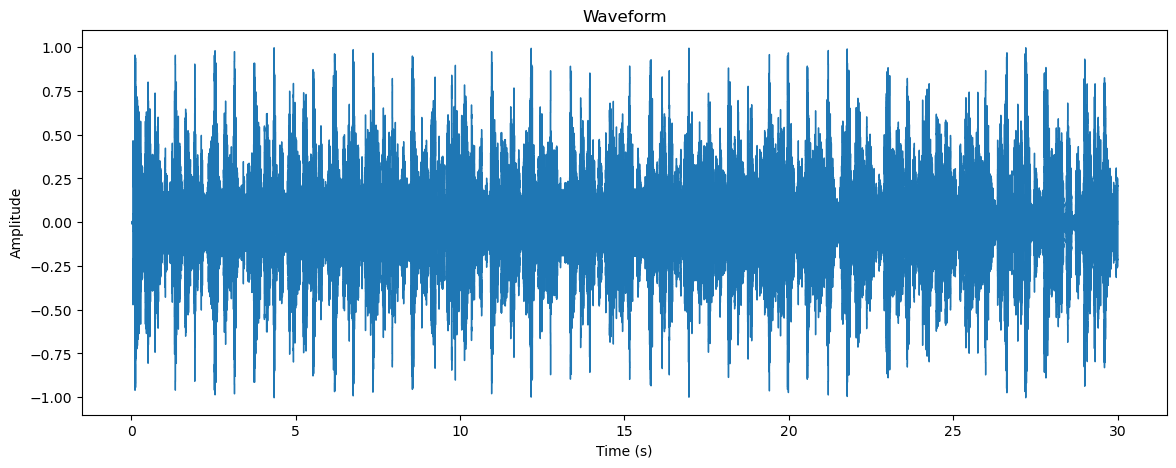

CPU times: user 3.09 s, sys: 503 ms, total: 3.6 s
Wall time: 1.6 s


In [53]:
%%time
#a) carregar áudio
emb_list = []

for file in files_db[:1]:
    audio, fs = get_audio(audiofile=file)
    plot_waveform(audio)
    audio_frames = nframe(audio, int(win_size_sec * fs), int(hop_size_sec*fs))
    audio_frames = np.transpose(audio_frames[np.newaxis, ...], (2, 0,1))
    
    # b) gerar o embedded
    emb = predict(audio_frames, m_pre, m_fp) # tensor 1 - TensorShape([473, 128])
    emb = emb.numpy() # tensor 1 - (473, 128)

    emb_list.append(emb)

emb_list_array = np.concatenate(emb_list, axis = 0)

In [26]:
query, query_shape = load_memmap_data(emb_dir, 'query')

Load 29,500 items from /mnt/dev/rodrigoalmeida/neural-audio-fp/logs/emb/CHECK_BFTRI_100/101/query.mm.


In [ ]:
csv_data = []

start = 0
sl = 5

db_startIndex = 53754198

counter_5seg = 0

#dbsmall = db[:80]

true_labels = []  # Lista para armazenar os rótulos verdadeiros
predicted_labels = []  # Lista para armazenar os rótulos previstos

for start in range(len(db)):
    print(start)
    q = db[start:start+sl,:]
    _, I = faiss_engine.search(q, 20) # D: Distâncias, I: Índices dos resultados
    
    for offset in range(len(I)):
        I[offset, :] -= offset

    candidates = np.unique(I[np.where(I >= 0)])   # ignore id < 0


    # Sequence match score 
    _scores = np.zeros(len(candidates))
    for ci, cid in enumerate(candidates):
        _scores[ci] = np.mean(
            np.diag(
                # np.dot(q, index.reconstruct_n(cid, (cid + l)).T)
                np.dot(q, fake_recon_index[cid:cid + q.shape[0], :].T)
                )
            )

    # Evaluate 
    pred_ids = candidates[np.argsort(-_scores)[:10]]

    #if pred_ids[0] == 53754198+start:
    #true_label = 53754198+start

    if pred_ids[0] >= db_startIndex + start and pred_ids[0] <= db_startIndex + start + sl:

        counter_5seg += 1
        musica_encontrada = musica(music_names, pred_ids, 0)
        print(musica_encontrada)

        valor = sorted(_scores)[0:0+1][0]
        csv_data.append(valor)

        #true_labels.append(true_label)
        #predicted_labels.append(pred_ids[0])

#cm = confusion_matrix(true_labels, predicted_labels)

In [28]:
len(csv_data)

9341

In [30]:
np.min(csv_data), np.max(csv_data), np.mean(csv_data), counter_5seg

(-0.05566946417093277, 0.7469334602355957, 0.14596916391332684, 9341)

In [ ]:
del csv_data, counter_3seg

In [ ]:
"""
start = 0
sl = 3

counter_3seg = 0

for start in range(len(db)):
    print(start)
    q = db[start:start+sl,:]
    _, I = faiss_engine.search(q, 20) # D: Distâncias, I: Índices dos resultados
    
    for offset in range(len(I)):
        I[offset, :] -= offset

    candidates = np.unique(I[np.where(I >= 0)])   # ignore id < 0


    # Sequence match score 
    _scores = np.zeros(len(candidates))
    for ci, cid in enumerate(candidates):
        _scores[ci] = np.mean(
            np.diag(
                # np.dot(q, index.reconstruct_n(cid, (cid + l)).T)
                np.dot(q, fake_recon_index[cid:cid + q.shape[0], :].T)
                )
            )

    # Evaluate
    pred_ids = candidates[np.argsort(-_scores)[:10]]

    if pred_ids[0] == 53754198+start:
        counter_3seg += 1
        musica_encontrada = musica(music_names, pred_ids, 0)
        print(musica_encontrada)

"""

In [1234]:
counter_1seg

29126

In [1161]:
sorted(np.load(glob.glob('./**/test_ids_icassp2021.npy', recursive=True)[0]))

[13,
 24,
 29,
 58,
 64,
 76,
 103,
 112,
 119,
 121,
 127,
 130,
 142,
 144,
 160,
 162,
 177,
 186,
 219,
 229,
 318,
 319,
 336,
 342,
 343,
 349,
 378,
 470,
 482,
 483,
 484,
 487,
 499,
 503,
 511,
 518,
 560,
 562,
 573,
 590,
 599,
 613,
 632,
 635,
 651,
 661,
 663,
 729,
 736,
 738,
 750,
 756,
 778,
 788,
 793,
 804,
 809,
 813,
 851,
 867,
 873,
 886,
 915,
 923,
 930,
 947,
 958,
 959,
 971,
 972,
 995,
 1002,
 1004,
 1053,
 1056,
 1061,
 1086,
 1094,
 1097,
 1136,
 1141,
 1160,
 1188,
 1202,
 1207,
 1211,
 1222,
 1235,
 1271,
 1275,
 1289,
 1303,
 1307,
 1310,
 1312,
 1314,
 1337,
 1357,
 1372,
 1374,
 1385,
 1424,
 1439,
 1458,
 1462,
 1472,
 1485,
 1499,
 1507,
 1525,
 1526,
 1541,
 1544,
 1563,
 1572,
 1573,
 1577,
 1608,
 1610,
 1615,
 1627,
 1642,
 1644,
 1654,
 1657,
 1672,
 1696,
 1697,
 1716,
 1723,
 1725,
 1726,
 1745,
 1751,
 1752,
 1756,
 1764,
 1776,
 1782,
 1790,
 1795,
 1801,
 1815,
 1838,
 1850,
 1886,
 1894,
 1898,
 1904,
 1919,
 1922,
 1954,
 1959,
 1985,

In [31]:
start = 0
sl = 0

In [32]:
#q = query[start:start+sl,:]
q = db[start:start+sl,:]

In [34]:
%%time
# c) Buscar o índice
D, I = faiss_engine.search(q, 20) # D: Distâncias, I: Índices dos resultados

CPU times: user 8.52 s, sys: 19.8 ms, total: 8.54 s
Wall time: 1.88 s


In [35]:
II=I
for offset in range(len(II)):
    II[offset, :] -= offset

In [36]:
II

array([[53754754, 53754746, 53754778, 41000061, 53754786, 39392377,
        53754745, 12576443, 14790680, 12576445, 53754787, 39267231,
        39392363, 29861837, 47912549, 38197881, 41079207, 39267015,
        15608575, 41000062],
       [53754754, 53754778, 53754775, 53754786, 53754746, 53754783,
        53754780, 53754748, 53754781, 53754750, 53754751, 53754774,
        53754784, 53754745, 39392377, 53754779, 39392381, 53754742,
        39392365, 53754743],
       [53754754, 53754742, 53754778, 53754783, 53754739, 53754775,
        53754746, 53754772, 53754755, 53754750, 53754748, 53754771,
        53754740, 53754751, 53754780, 53754747, 53754779, 26169162,
        10321119, 53754774],
       [53754754, 53754755, 53754730, 53754770, 53754759, 53754768,
        53754734, 53754732, 53754731, 53754726, 53754727, 53754729,
        53754767, 53754733, 53754769, 53754753, 53754758, 53754763,
        53754765, 53754761],
       [53754754, 53754729, 53754763, 53754762, 53754753, 53754767,


In [37]:
#D

In [38]:
candidates, idx_unique_candidates = np.unique(II[np.where(II >= 0)], return_index=True)
candidates = np.unique(II[np.where(II >= 0)])   # ignore id < 0
print(f"candidates-{candidates}")

#Eliminar as distâncias dos índices duplicados
D_array = D[np.where(II >= 0)]
DD = D_array[idx_unique_candidates]
print(f"\n\nDistantces of candidates-{DD}")

candidates-[10321119 12576443 12576445 14790680 15608575 26169162 29861837 38197881
 39267015 39267231 39392363 39392365 39392377 39392381 41000061 41000062
 41079207 47912549 53754712 53754713 53754714 53754715 53754716 53754717
 53754718 53754719 53754720 53754721 53754722 53754723 53754724 53754725
 53754726 53754727 53754728 53754729 53754730 53754731 53754732 53754733
 53754734 53754739 53754740 53754741 53754742 53754743 53754744 53754745
 53754746 53754747 53754748 53754749 53754750 53754751 53754752 53754753
 53754754 53754755 53754756 53754757 53754758 53754759 53754760 53754761
 53754762 53754763 53754764 53754765 53754766 53754767 53754768 53754769
 53754770 53754771 53754772 53754774 53754775 53754778 53754779 53754780
 53754781 53754783 53754784 53754786 53754787]


Distantces of candidates-[0.7364216  0.722735   0.7483541  0.740653   0.76913416 0.7240765
 0.75658476 0.7649349  0.7684398  0.75237554 0.7535751  0.7217605
 0.7117813  0.71225595 0.5944781  0.7724645  0.767282

In [39]:
""" Sequence match score """
_scores = np.zeros(len(candidates))
for ci, cid in enumerate(candidates):
    _scores[ci] = np.mean(
        np.diag(
            # np.dot(q, index.reconstruct_n(cid, (cid + l)).T)
            np.dot(q, fake_recon_index[cid:cid + q.shape[0], :].T)
            )
        )

In [40]:
#_scores

In [41]:
""" Evaluate """
pred_ids = candidates[np.argsort(-_scores)[:10]]
pred_Distances = DD[np.argsort(-_scores)[:10]]

In [42]:
53754198+start

53754754

In [43]:
music_names[53754198+start]

'001108'

In [44]:
pred_ids, pred_Distances, sorted(_scores)[:10]

(array([53754754, 53754755, 53754753, 53754756, 53754750, 53754752,
        53754746, 53754751, 53754758, 53754749]),
 array([0.00805327, 0.5470998 , 0.5504346 , 0.41763964, 0.5656354 ,
        0.4103681 , 0.29466894, 0.59701264, 0.55814207, 0.4252189 ],
       dtype=float32),
 [0.08285487443208694,
  0.1055712178349495,
  0.10781948268413544,
  0.11279012262821198,
  0.11556871235370636,
  0.12409422546625137,
  0.14435848593711853,
  0.15246500074863434,
  0.1524863988161087,
  0.1541849821805954])

In [45]:
TruePositive = 0
TrueNegative = 0
FalsePositve = 0
FalseNegative = 0

db_startIndex = 53754198

if pred_ids[0] >= db_startIndex+start and pred_ids[0] <= db_startIndex+start+sl: #and a musica pertence à base de dados: db, query
    TruePositive += 1

if pred_ids[0] <= db_startIndex+start and pred_ids[0] >= db_startIndex+start+sl: #and a musica pertence à base de dados: db, query
    FalseNegative += 1

if pred_ids[0] >= db_startIndex+start and pred_ids[0] <= db_startIndex+start+sl: #and a musica não pertence à base de dados
    FalsePositve += 1

if pred_ids[0] <= db_startIndex+start and pred_ids[0] >= db_startIndex+start+sl: #and a musica não pertence à base de dados
    TrueNegative += 1

In [46]:
query_length_limiar = {
    1: 0.852932, #0.852932,
    3: 0.2,
    5: 0.05,
    9: 0.03,
    11: 0.02,
    19: 0.09 #0.006
}

In [47]:
for i, pred_id in enumerate(pred_ids):
    print(i)
    print(sorted(_scores)[i:i+1][0])
    if sorted(_scores)[i:i+1][0] < query_length_limiar.get(q.shape[0]):# and sorted(_scores)[i:i+1][0] > 0: #verificar se este último é realmente verdade
        musica_encontrada = musica(music_names, pred_ids, 0)
        print(musica_encontrada)
        break
    
    if i == len(pred_ids)-1:
        print("Não encontrou a música.")

0
0.08285487443208694


001108
     track_id  artist_name track_title
843      1108  Mayor Daley      Song 4


In [ ]:
if pred_Distances[0] < 0.8:
    music_names = np.array(music_names)

    map_obra = lambda idx: music_names[idx]

    obras_result = map_obra(pred_ids[0])

    print(obras_result)

    linha_encontrada = df[df.iloc[:, 0] == int(obras_result)]
    
    print(linha_encontrada)

else:
    print("Não conseguiu encontrar a música. Tente novamente.")

## FalseDB

In [55]:
#filesdir_falseBD = '/mnt/dataset/public/Fingerprinting/FalseBD/'

music1 = '/mnt/dataset/public/Fingerprinting/FalseBD/eterna-cancao-wav-12569.wav'
music2 = '/mnt/dataset/public/Fingerprinting/FalseBD/new-edm-music-beet-mr-sandeep-rock-141616.wav'
music3 = '/mnt/dataset/public/Fingerprinting/FalseBD/see-you-later-203103.wav'

filesdir_falseBD = music2

#files_falseBD = glob.glob(os.path.join(filesdir_falseBD, '**/*.wav') ,recursive = True)
files_falseBD = glob.glob(os.path.join(filesdir_falseBD) ,recursive = True)
files_falseBD = sorted(files_falseBD)

In [56]:
files_falseBD

['/mnt/dataset/public/Fingerprinting/FalseBD/new-edm-music-beet-mr-sandeep-rock-141616.wav']

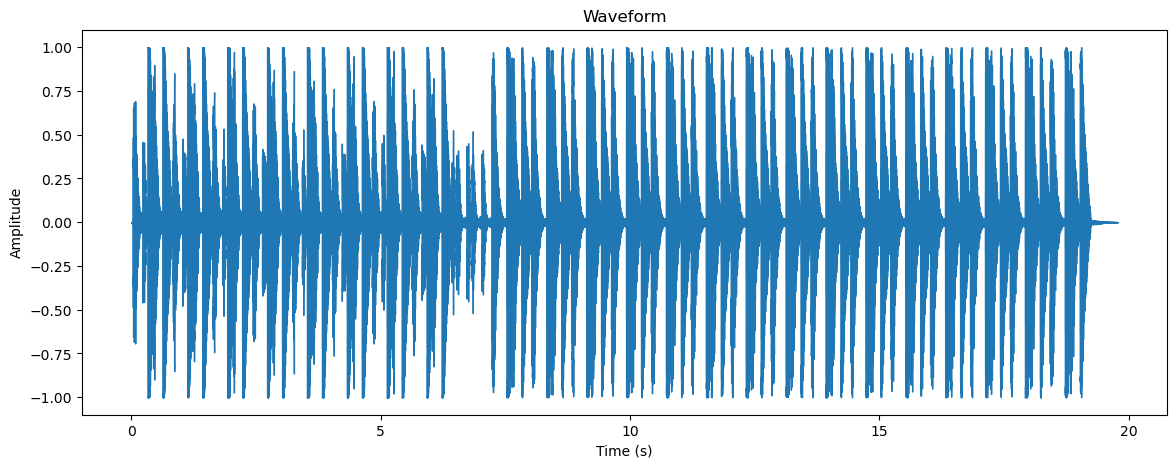

CPU times: user 6.12 s, sys: 351 ms, total: 6.47 s
Wall time: 5.19 s


In [57]:
%%time
#a) carregar áudio
emb_list = []

for file in files_falseBD:
    audio, fs = get_audio(audiofile=file)
    plot_waveform(audio)
    audio_frames = nframe(audio, int(win_size_sec * fs), int(hop_size_sec*fs))
    audio_frames = np.transpose(audio_frames[np.newaxis, ...], (2, 0,1))
    
    # b) gerar o embedded
    emb = predict(audio_frames, m_pre, m_fp) # tensor 1 - TensorShape([473, 128])
    emb = emb.numpy() # tensor 1 - (473, 128)

    emb_list.append(emb)

emb_list_array = np.concatenate(emb_list, axis = 0)

In [ ]:
q=emb_list_array

In [ ]:
%%time
# c) Buscar o índice
D, I = faiss_engine.search(q, 20) # D: Distâncias, I: Índices dos resultados

CPU times: user 17 s, sys: 23.5 ms, total: 17.1 s
Wall time: 3.65 s


In [ ]:
#q=emb_list_array
#q=q[:20]
q.shape

(38, 128)

In [ ]:
for offset in range(len(I)):
    I[offset, :] -= offset


candidates, idx_unique_candidates = np.unique(I[np.where(I >= 0)], return_index=True)
#candidates = np.unique(I[np.where(I >= 0)])   # ignore id < 0
print(f"candidates-{candidates}")

""" Sequence match score """
_scores = np.zeros(len(candidates))
for ci, cid in enumerate(candidates):
    _scores[ci] = np.mean(
        np.diag(
            # np.dot(q, index.reconstruct_n(cid, (cid + l)).T)
            np.dot(q, fake_recon_index[cid:cid + q.shape[0], :].T)
            )
        )

""" Evaluate """
pred_ids = candidates[np.argsort(-_scores)[:10]]
print(np.argsort(-_scores))


query_length_limiar = {
    1: 0.852932, #0.852932,
    3: 0.2,
    5: 0.05,
    9: 0.03,
    11: 0.02,
    19: 0.006
}

print(f"pred_ids-{pred_ids}")
print(f"scores-{sorted(_scores)[:10]}")
print(f"scores->{sorted(_scores)[0:0+1][0]}")

def  get_threshold(q_shape_0):

    valid_keys = [key for key in query_length_limiar.keys() if key <= q_shape_0]

    if valid_keys:
        # Selecionar a maior dessas chaves
        selected_key = max(valid_keys)
        return query_length_limiar[selected_key]


threshold = get_threshold(q.shape[0])
print(f"threshold-{-threshold}")

print(f"Verdadeiro_Falso-{pred_ids[0]== db_startIndex+q.shape[0]}")
 

for i, pred_id in enumerate(pred_ids):
    

    if sorted(_scores)[i:i+1][0] < threshold and sorted(_scores)[i:i+1][0] > 0: #verificar se este último é realmente verdade
        musica_encontrada = musica(music_names, pred_ids, 0)
        print(musica_encontrada)
        print(i)
        break
    
    if i == len(pred_ids)-1:
        print("Não encontrou a música.")

candidates-[   53732    53760    53956    54068    54075    92650    92664    92762
    92776    92780    92874    92888    92892   176680   176792   176904
   177016   177128   606156   865141   974582  1216645  1216673  1216757
  1216897  1217065  1265821  1266045  1295758  1793842  1794066  1858220
  2111098  2111308  2111322  2111420  2452317  3160189  3561126  3561238
  3561462  3561574  4309969  4337531  5105294  5105406  5424013  5424027
  5424069  5424125  5424181  5424237  5424293  5424349  5424363  5424405
  5424517  5551731  5551955  5826767  6073887  6073999  6074111  6075383
  6075495  6075607  6075714  6075726  6075845  6114658  6215959  6215987
  6216099  6216113  6216211  6216295  6216309  6216351  6216421  6216435
  6216463  6216604  6217055  6217279  6217503  6289842  6380603  6380701
  6380715  6380813  6380827  6380925  6380926  6380939  6380940  6381051
  6554752  6554794  6554808  6554836  6554906  6554920  6554948  6555018
  6555032  6555060  6555074  6555144  65

In [ ]:
sorted(_scores)[i:i+1][0]

-0.03359659016132355

In [ ]:
-0.12 < -0.06

True